Process whole plane for plane 2 without any downsampling

In [1]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, auc
import qkeras
from qkeras import *
from skimage.measure import block_reduce

2023-10-29 13:35:03.243342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/nevis/westside/data/sc5303/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


# Data Files

In [2]:
# Open the HDF5 file
file_path = '/nevis/westside/data/sc5303/Data/bnb_WithWire_16.h5'

with h5py.File(file_path, 'r') as hf:
    # Access the "wire_table" group
    wire_table_group = hf['wire_table']
    startEvt = 0
    endEvt = 100
    nEvt = endEvt - startEvt
    # Define the start and end indices for the subset you want to load

    # Load the subsets of the data using slicing and convert them to DataFrames
    event_ids = [wire_table_group['event_id'][Evt*8256] for Evt in range(startEvt, endEvt)]
    planeadcs = [wire_table_group['adc'][4800+Evt*8256:8256+Evt*8256] for Evt in range(startEvt, endEvt)]

    ntimeticks=6400
    nplanes=len(planeadcs)


    f_downsample = 10
    for p in range(0,nplanes):
        planeadcs[p] = block_reduce(planeadcs[p], block_size=(1,f_downsample), func=np.sum)

    adccutoff = 10.*f_downsample/10.
    adcsaturation = 100.*f_downsample/10.
    for p in range(0,nplanes):
        planeadcs[p][planeadcs[p]<adccutoff] = 0
        planeadcs[p][planeadcs[p]>adcsaturation] = adcsaturation


In [3]:
f_split = 10
X = np.array(np.split(np.array(planeadcs), f_split, axis=2))
print(np.shape(planeadcs))
X = np.reshape(X, (-1,3456,640//f_split,1))
print('X      shape: ' + str(X.shape))

(100, 3456, 640)
X      shape: (1000, 3456, 64, 1)


In [4]:
f_split = 1
full = np.array(np.split(np.array(planeadcs), f_split, axis=2))
full = np.reshape(full, (-1,3456,640//f_split,1))
print('full      shape: ' + str(full.shape))

full      shape: (100, 3456, 640, 1)


In [5]:
train_ratio = 0.5
val_ratio = 0.1
test_ratio = 1 - train_ratio - val_ratio

# Create an array of original indices
original_indices = np.arange(X.shape[0])

# Perform the train/test split
X_train_val_indices, X_test_indices = train_test_split(original_indices, test_size=test_ratio, random_state=42)
X_train_indices, X_val_indices = train_test_split(X_train_val_indices, test_size=val_ratio / (val_ratio + train_ratio), random_state=42)
del X_train_val_indices
# Use the indices to access the corresponding data
X_test = X[X_test_indices]
X_train = X[X_train_indices]
X_val = X[X_val_indices]

# X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 42)
# X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 42)
# del X_train_val

print('X_train shape: ' + str(X_train.shape))
print('X_val   shape: ' + str(X_val.shape))
print('X_test  shape: ' + str(X_test.shape))


X_train shape: (499, 3456, 64, 1)
X_val   shape: (101, 3456, 64, 1)
X_test  shape: (400, 3456, 64, 1)


# CNN AE (teacher model)

In [6]:
encoder_input = tf.keras.Input(shape=(3456,64,1), name='input')

encoder = layers.Conv2D(20, (3,3), strides=1, padding='same', name='conv2d_1')(encoder_input)
encoder = layers.Activation('relu', name='relu_1')(encoder)
encoder = layers.AveragePooling2D((2,2), name='pool_1')(encoder)
encoder = layers.Conv2D(30, (3,3), strides=1, padding='same', name='conv2d_2')(encoder)
encoder = layers.Activation('relu', name='relu_2')(encoder)
encoder = layers.Flatten(name='flatten')(encoder)

encoder_output = layers.Dense(80, activation='relu', name='latent')(encoder)

encoder = tf.keras.models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3456, 64, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3456, 64, 20)      200       
                                                                 
 relu_1 (Activation)         (None, 3456, 64, 20)      0         
                                                                 
 pool_1 (AveragePooling2D)   (None, 1728, 32, 20)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1728, 32, 30)      5430      
                                                                 
 relu_2 (Activation)         (None, 1728, 32, 30)      0         
                                                                 
 flatten (Flatten)           (None, 1658880)           0     

2023-10-29 13:35:39.664444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 13:35:40.470679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11445 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:01:00.0, compute capability: 6.1
2023-10-29 13:35:40.471195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11445 MB memory:  -> device: 1, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:02:00.0, compute capability: 6.1


In [7]:
decoder = layers.Dense(1728*32*30, name='dense')(encoder_output)
decoder = layers.Reshape((1728,32,30), name='reshape2')(decoder)
decoder = layers.Activation('relu', name='relu_3')(decoder)
decoder = layers.Conv2D(30, (3,3), strides=1, padding='same', name='conv2d_3')(decoder)
decoder = layers.Activation('relu', name='relu_4')(decoder)
decoder = layers.UpSampling2D((2,2), name='upsampling')(decoder)
decoder = layers.Conv2D(20, (3,3), strides=1, padding='same', name='conv2d_4')(decoder)
decoder = layers.Activation('relu', name='relu_5')(decoder)

decoder_output = layers.Conv2D(1, (3,3), activation='relu', strides=1, padding='same', name='output')(decoder)

In [8]:
teacher = tf.keras.Model(encoder_input, decoder_output)
teacher.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3456, 64, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3456, 64, 20)      200       
                                                                 
 relu_1 (Activation)         (None, 3456, 64, 20)      0         
                                                                 
 pool_1 (AveragePooling2D)   (None, 1728, 32, 20)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1728, 32, 30)      5430      
                                                                 
 relu_2 (Activation)         (None, 1728, 32, 30)      0         
                                                                 
 flatten (Flatten)           (None, 1658880)           0   

In [9]:
teacher.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = 'mse')

# Training

In [10]:
history = teacher.fit(X_train, X_train,
                      epochs = 40,
                      validation_data = (X_val, X_val),
                      batch_size = 32)

Epoch 1/40


2023-10-29 13:35:49.195707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2023-10-29 13:35:49.534501: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-29 13:35:52.092755: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f10d977f440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-29 13:35:52.092782: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA TITAN X (Pascal), Compute Capability 6.1
2023-10-29 13:35:52.092787: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA TITAN X (Pascal), Compute Capability 6.1
2023-10-29 13:35:52.096217: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-29 13:35:52.153340: I tensorflow/tsl/platform

16/16 [==============================] - 15s 488ms/step - loss: 17.9872 - val_loss: 19.1980
Epoch 2/40
16/16 [==============================] - 4s 245ms/step - loss: 18.0216 - val_loss: 19.2380
Epoch 3/40
16/16 [==============================] - 4s 245ms/step - loss: 17.7969 - val_loss: 19.1650
Epoch 4/40
16/16 [==============================] - 4s 245ms/step - loss: 17.2290 - val_loss: 19.1154
Epoch 5/40
16/16 [==============================] - 4s 245ms/step - loss: 15.9326 - val_loss: 19.1582
Epoch 6/40
16/16 [==============================] - 4s 245ms/step - loss: 14.3857 - val_loss: 19.2001
Epoch 7/40
16/16 [==============================] - 4s 245ms/step - loss: 12.3760 - val_loss: 19.2157
Epoch 8/40
16/16 [==============================] - 4s 246ms/step - loss: 10.6050 - val_loss: 19.1966
Epoch 9/40
16/16 [==============================] - 4s 245ms/step - loss: 8.9604 - val_loss: 19.1927
Epoch 10/40
16/16 [==============================] - 4s 246ms/step - loss: 7.8744 - val_loss:

Text(0, 0.5, 'Loss')

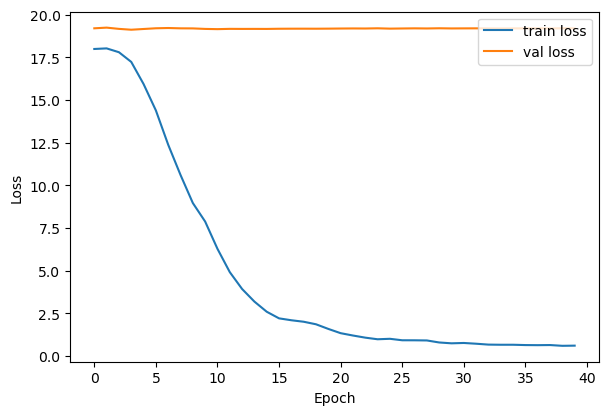

In [11]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# Save/load trained models

In [18]:
teacher.save('/nevis/westside/data/sc5303/saved_models/teacher_slices64')

INFO:tensorflow:Assets written to: /nevis/westside/data/sc5303/saved_models/teacher_slices64/assets


INFO:tensorflow:Assets written to: /nevis/westside/data/sc5303/saved_models/teacher_slices64/assets


In [ ]:
teacher = tf.keras.models.load_model('saved_models/teacher2023_aug1')
teacher.summary()

In [ ]:
#student.save('saved_models/student2023_aug1_v1/')
student.save('saved_models/student2023_aug1_v2/')

In [ ]:
tf.get_logger().setLevel('ERROR')
#student = qkeras.utils.load_qmodel('saved_models/student2023_aug1_v1') # 2023 v1
student = qkeras.utils.load_qmodel('saved_models/student2023_aug1_v2') # 2023 v2
student.summary()
student.get_config()

# Loss distribution

In [12]:
X_train_predict_teacher = teacher.predict(X_train)
X_val_predict_teacher = teacher.predict(X_val)
X_test_predict_teacher = teacher.predict(X_test)

 3/16 [====>.........................] - ETA: 0s

2023-10-29 02:00:55.220006: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-29 02:00:55.220048: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


12/13 [==========================>...] - ETA: 0s

2023-10-29 02:00:58.295793: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-29 02:00:58.295828: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


13/13 [==============================] - 2s 133ms/step


In [12]:
def loss(y_true, y_pred, choice):
    if choice == 'mse':
        loss = np.mean((y_true - y_pred)**2, axis = (1,2,3))
        return loss

In [13]:
X_train_loss_teacher = loss(X_train, X_train_predict_teacher, 'mse')
X_val_loss_teacher = loss(X_val, X_val_predict_teacher, 'mse')
X_test_loss_teacher = loss(X_test, X_test_predict_teacher, 'mse')

NameError: name 'X_train_predict_teacher' is not defined

In [14]:
X_predict_teacher = teacher.predict(X)
X_loss_teacher = loss(X, X_predict_teacher, 'mse')

 4/32 [==>...........................] - ETA: 1s

2023-10-29 13:39:01.902123: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-29 13:39:01.902160: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


32/32 [==============================] - 3s 74ms/step


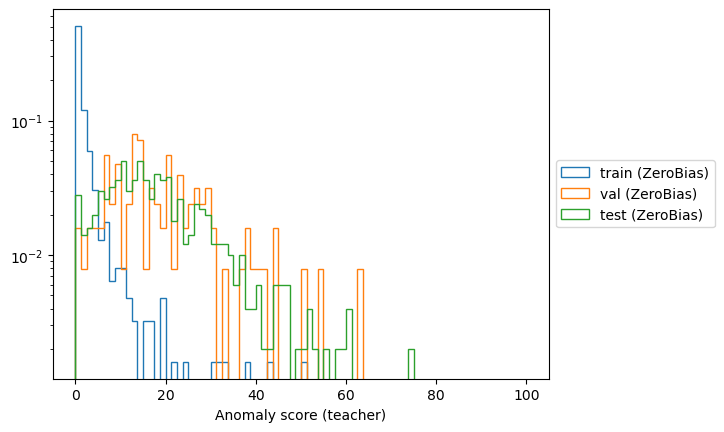

In [16]:
nbins = 80
rmin = 0
rmax = 100
plt.hist(X_train_loss_teacher, density = 1, bins = nbins, alpha = 1, label = 'train (ZeroBias)', range = (rmin, rmax), log = True, histtype='step')
plt.hist(X_val_loss_teacher, density = 1, bins = nbins, alpha = 1, label = 'val (ZeroBias)', range = (rmin, rmax), log = True, histtype='step')
plt.hist(X_test_loss_teacher, density = 1, bins = nbins, alpha = 1, label = 'test (ZeroBias)', range = (rmin, rmax), log = True, histtype='step')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Anomaly score (teacher)")
plt.show()

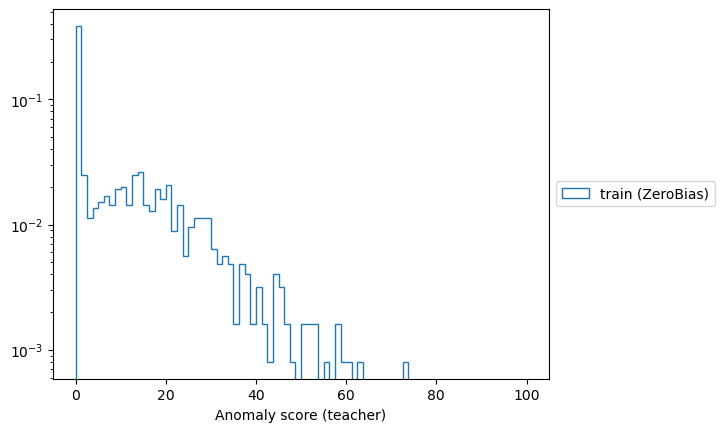

In [15]:
nbins = 80
rmin = 0
rmax = 100
plt.hist(X_loss_teacher, density = 1, bins = nbins, alpha = 1, label = 'train (ZeroBias)', range = (rmin, rmax), log = True, histtype='step')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Anomaly score (teacher)")
plt.show()

In [17]:
# Use boolean indexing to get the indices of values over the threshold
indices = np.where(X_loss_teacher > 50)

# Convert the indices to a list (if needed)
indices_list = indices[0].tolist()

zmax = adcsaturation

# Turn off interactive plotting
plt.ioff()

for evt in indices_list:
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 15), dpi=600)
    true_indice = evt
    
    # Transpose the image
    transposed_image = X[true_indice][:, :, 0].T

    im1 = ax1.imshow(transposed_image, vmin=0, vmax=zmax, origin='lower', cmap='jet')
    ax1.set_title(f"Plane 2 run{event_ids[true_indice%nEvt][0]}, subrun{event_ids[true_indice%nEvt][1]}, event{event_ids[true_indice%nEvt][2]}, line:{true_indice//nEvt}, anomaly score: {X_loss_teacher[true_indice]:.2f}")
    ax1.set_xlabel("Wire")
    ax1.set_ylabel("Time Tick")

    # Save the figure without displaying it
    fig.savefig(f'output/strips64/teacher/{event_ids[true_indice%nEvt]}.png')
    # Close the figure to release resources
    plt.close(fig)


    fig, ax1 = plt.subplots(1, 1, figsize=(20, 15), dpi=600)
    true_indice = evt
    
    # Transpose the image
    transposed_image = full[true_indice%nEvt][:, :, 0].T

    im1 = ax1.imshow(transposed_image, vmin=0, vmax=zmax, origin='lower', cmap='jet')
    ax1.set_title(f"Plane 2 run{event_ids[true_indice%nEvt][0]}, subrun{event_ids[true_indice%nEvt][1]}, event{event_ids[true_indice%nEvt][2]}, line:{true_indice//nEvt}, anomaly score: {X_loss_teacher[true_indice]:.2f}")
    ax1.set_xlabel("Wire")
    ax1.set_ylabel("Time Tick")
    ax1.axhline((true_indice//nEvt)*64, linewidth=0.5, color='yellow', ls='-')
    ax1.axhline((true_indice//nEvt+1)*64, linewidth=0.5, color='yellow', ls='-')

    # Save the figure without displaying it
    fig.savefig(f'output/strips64/full/{event_ids[true_indice%nEvt]}.png')
    # Close the figure to release resources
    plt.close(fig)

# Turn interactive plotting back on
plt.ion()

# Comparison between original and reconstructed inputs

In [ ]:
show_ZB = True
# show_ZB = False
n = 3
for i in range(280,300):
    fig, ax = plt.subplots(figsize = (17,17))
    if show_ZB == True:
        print('ZB test\nloss = ' + str(X_test_loss_teacher[i]))
    else:
        print(str(MC_files[n]) + '\nloss = ' + str(MC_flag_loss_teacher[n][i]))
    ax = plt.subplot(3, 3, 1)
    if show_ZB == True:
        ax = sns.heatmap(X_test[i].reshape(24, 20), vmin = 0, vmax = X_test[i].max(), cmap = "Purples", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC_flag[n][i].reshape(18, 14), vmin = 0, vmax = MC_flag[n][i].max(), cmap = "Purples", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original')
    
    ax = plt.subplot(3, 3, 2)
    if show_ZB == True:
        ax = sns.heatmap(X_test_predict_teacher[i].reshape(24, 20), vmin = 0, vmax = X_test[i].max(), cmap = "Purples", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC_flag_predict_teacher[n][i].reshape(18, 14), vmin = 0, vmax = MC_flag[n][i].max(), cmap = "Purples", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed')
    
    ax = plt.subplot(3, 3, 3)
    if show_ZB == True:
        ax = sns.heatmap(np.absolute(X_test_predict_teacher[i].reshape(24, 20) - X_test[i].reshape(24, 20)), vmin = 0, vmax = X_test[i].max(), cmap = "Purples", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(np.absolute(MC_flag_predict_teacher[n][i].reshape(18, 14) - MC_flag[n][i].reshape(18, 14)), vmin = 0, vmax = MC_flag[n][i].max(), cmap = "Purples", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('abs(original-reconstructed)')

    plt.show()

# Knowledge Distillation (+ quantizing with QKeras)

In [ ]:
# v1
x_in = layers.Input(shape=(480,), name="In")

x = QDense(15, kernel_quantizer=quantized_bits(2, 0, 1, alpha=1.0),
           use_bias=False, name='dense1')(x_in)
x = QBatchNormalization(beta_quantizer=quantized_bits(10, 2, 1, alpha='auto'),
                        gamma_quantizer=quantized_bits(10, 2, 1, alpha='auto'),
                        mean_quantizer=quantized_bits(10, 2, 1, alpha='auto'),
                        variance_quantizer=quantized_bits(10, 2, 1, alpha='auto'),
                        name = 'QBN1')(x)
x = QActivation('quantized_relu(5, 2)', name='relu1')(x)
x = QDense(1, kernel_quantizer=quantized_bits(4, 0, 1, alpha=1.0),
           use_bias=False, name='output')(x)

student = tf.keras.models.Model(x_in, x)
student.summary()
student.compile(optimizer = 'adam', loss = 'mse')

In [19]:
# v2
x_in = layers.Input(shape=(221184,), name="In")
x = layers.Reshape((3456,64,1), name='reshape')(x_in)

x = QConv2D(3,(3,3), strides=2, padding="valid", use_bias=False,
            kernel_quantizer=quantized_bits(16,4,1,alpha='auto'), name='conv')(x)
x = QActivation('quantized_relu(16,4)', name='relu1')(x)
x = layers.Flatten(name='flatten')(x)
x = QDense(20, kernel_quantizer=quantized_bits(16,4,1,alpha='auto'),
           use_bias=False, name='dense1')(x)
x = QActivation('quantized_relu(16,4)', name='relu2')(x)
x = QDense(1, kernel_quantizer=quantized_bits(16,2,1,alpha='auto'),
           use_bias=False, name='output')(x)

student = tf.keras.models.Model(x_in, x)
student.summary()
student.compile(optimizer = 'adam', loss = 'mse')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 In (InputLayer)             [(None, 221184)]          0         
                                                                 
 reshape (Reshape)           (None, 3456, 64, 1)       0         
                                                                 
 conv (QConv2D)              (None, 1727, 31, 3)       27        
                                                                 
 relu1 (QActivation)         (None, 1727, 31, 3)       0         
                                                                 
 flatten (Flatten)           (None, 160611)            0         
                                                                 
 dense1 (QDense)             (None, 20)                3212220   
                                                                 
 relu2 (QActivation)         (None, 20)                0   

In [20]:
history = student.fit(X_train.reshape((-1,221184,1)), X_train_loss_teacher,
                      epochs = 30,
                      validation_data = (X_val.reshape((-1,221184,1)), X_val_loss_teacher),
                      batch_size = 128)

NameError: name 'X_train_loss_teacher' is not defined

Text(0, 0.5, 'Loss')

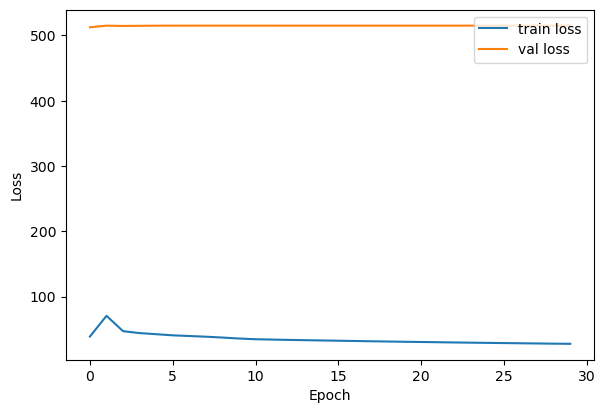

In [22]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
#axes.set_yscale(value = "log")
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [23]:
X_train_loss_student = student.predict(X_train.reshape((-1,221184,1)))
X_val_loss_student = student.predict(X_val.reshape((-1,221184,1)))
X_test_loss_student = student.predict(X_test.reshape((-1,221184,1)))
# MC_loss_student = []
# MC_flag_loss_student = []
# for i in range(len(MC)):
#     MC_loss_student.append(student.predict(MC[i].reshape((-1,252,1))))
#     MC_flag_loss_student.append(student.predict(MC_flag[i].reshape((-1,252,1))))

13/13 [==============================] - 0s 10ms/step


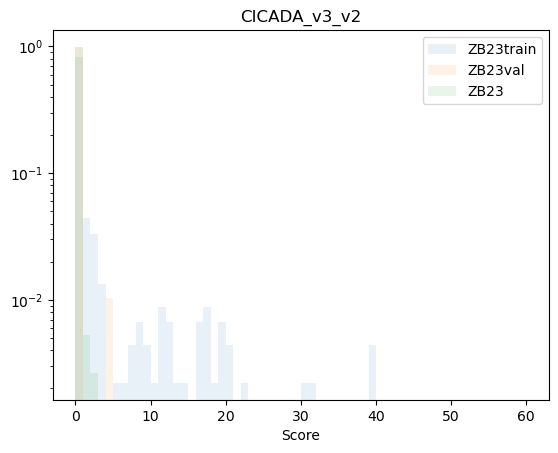

In [24]:
nbins = 60
rmin = 0
rmax = 60
plt.hist(X_train_loss_student, density = 1, bins = nbins, alpha = 0.1, label = 'ZB23train', range = (rmin, rmax), log = True)
plt.hist(X_val_loss_student, density = 1, bins = nbins, alpha = 0.1, label = 'ZB23val', range = (rmin, rmax), log = True)
plt.hist(X_test_loss_student, density = 1, bins = nbins, alpha = 0.1, label = 'ZB23', range = (rmin, rmax), log = True)
# plt.hist(MC_flag_loss_student[0], density = 1, bins = nbins, label = 'H_ToLongLived', color='green', histtype = 'step', range = (rmin, rmax))
# plt.hist(MC_flag_loss_student[1], density = 1, bins = nbins, label = 'SUEP', color='red', histtype = 'step', range = (rmin, rmax))
# plt.hist(MC_flag_loss_student[2], density = 1, bins = nbins, label = 'SUSYGGBBH', color='blue', histtype = 'step', range = (rmin, rmax))
# plt.hist(MC_flag_loss_student[3], density = 1, bins = nbins, label = 'TT', color='orange', histtype = 'step', range = (rmin, rmax))
# plt.hist(MC_flag_loss_student[4], density = 1, bins = nbins, label = 'VBFHto2C', color='purple', histtype = 'step', range = (rmin, rmax))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc='center left', bbox_to_anchor=(0.57, 0.5))
plt.title('CICADA_v3_v2')
plt.legend(loc='best')
plt.xlabel("Score")
#plt.xticks(np.arange(rmin, rmax, step = 0.0002))
plt.show()

In [25]:
X_loss_student = student.predict(X.reshape((-1,221184,1)))

32/32 [==============================] - 0s 9ms/step


In [28]:
# Use boolean indexing to get the indices of values over the threshold
indices = np.where(X_loss_student > 30)

# Convert the indices to a list (if needed)
indices_list = indices[0].tolist()

zmax = adcsaturation

# Turn off interactive plotting
plt.ioff()

for evt in indices_list:
    for i in range(-1,2):
        fig, ax1 = plt.subplots(1, 1, figsize=(20, 15), dpi=600)
        true_indice = evt+i
        
        # Transpose the image
        transposed_image = X[true_indice][:, :, 0].T

        im1 = ax1.imshow(transposed_image, vmin=0, vmax=zmax, origin='lower', cmap='jet')
        ax1.set_title(f"Plane 2 run{event_ids[true_indice//10][0]}, subrun{event_ids[true_indice//10][1]}, event{event_ids[true_indice//10][2]}, line:{true_indice-(true_indice//10)*10}, anomaly score: {float(X_loss_student[true_indice]):.2f}")
        ax1.set_xlabel("Wire")
        ax1.set_ylabel("Time Tick")

        # Save the figure without displaying it
        fig.savefig(f'output/strips64/student/{event_ids[true_indice//10]}_{i}.png')
        # Close the figure to release resources
        plt.close(fig)
# Turn interactive plotting back on
plt.ion()

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [ ]:
X_test_A_loss_student = student.predict(X_A.reshape((-1,252,1)))
X_test_B_loss_student = student.predict(X_B.reshape((-1,252,1)))
X_test_C_loss_student = student.predict(X_C.reshape((-1,252,1)))
X_test_D_loss_student = student.predict(X_D.reshape((-1,252,1)))
X_test_EphC_loss_student = student.predict(X_EphC.reshape((-1,252,1)))

In [ ]:
nbins = 100
rmin = 0
rmax = 25
plt.hist(X_test_A_loss_student, density = 1, bins = nbins, label = 'ZB23A', range = (rmin, rmax), log = True, histtype = 'step')
plt.hist(X_test_B_loss_student, density = 1, bins = nbins, label = 'ZB23B', range = (rmin, rmax), log = True, histtype = 'step')
plt.hist(X_test_C_loss_student, density = 1, bins = nbins, label = 'ZB23C', range = (rmin, rmax), log = True, histtype = 'step')
plt.hist(X_test_D_loss_student, density = 1, bins = nbins, label = 'ZB23D', range = (rmin, rmax), log = True, histtype = 'step')
plt.hist(X_test_EphC_loss_student, density = 1, bins = nbins, label = 'EZB23C', range = (rmin, rmax), log = True, histtype = 'step')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='center left', bbox_to_anchor=(0.57, 0.5))
plt.title('CICADA_v3_v2, scores on different ZB runs')
plt.legend(loc='best')
plt.xlabel("Score")
#plt.xticks(np.arange(rmin, rmax, step = 0.0002))
plt.show()

# ROC plotting

### Assigning labels and arranging for ROC plotting

In [ ]:
signal_acceptance_flag = True

#Assign labels for various signals (y = 1) and backgrounds (y = 0)
Y_bkg = np.zeros((X_test.shape[0], 1))
Y_sig = []
for i in range(len(MC)):
    if signal_acceptance_flag == False:
        Y_sig.append(np.ones((MC[i].shape[0], 1)))
    else:
        Y_sig.append(np.ones((MC_flag[i].shape[0], 1)))

#Concatenate datasets to make ROC curves

#True labels
Y_true = []
#Model scores
Y_teacher = []
Y_student = []

for i in range(len(MC)):
    if signal_acceptance_flag == False:
        Y_true.append(np.concatenate((Y_sig[i], Y_bkg)))
        Y_teacher.append(np.concatenate((MC_loss_teacher[i], X_test_loss_teacher)))
        Y_student.append(np.concatenate((MC_loss_student[i], X_test_loss_student)))
    else:
        Y_true.append(np.concatenate((Y_sig[i], Y_bkg)))
        Y_teacher.append(np.concatenate((MC_flag_loss_teacher[i], X_test_loss_teacher)))
        Y_student.append(np.concatenate((MC_flag_loss_student[i], X_test_loss_student)))

### Teacher model ROC

In [ ]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_teacher = []
tpr_teacher = []
thresholds_teacher = []
roc_auc_teacher = []
for i in range(len(MC)):
    fpr_teacher.append(np.empty((Y_true[i].shape[0],1)))
    tpr_teacher.append(np.empty((Y_true[i].shape[0],1)))
    thresholds_teacher.append(np.empty((Y_true[i].shape[0],1)))
    roc_auc_teacher.append(np.empty((Y_true[i].shape[0],1)))
    fpr_teacher[i], tpr_teacher[i], thresholds_teacher[i] = roc_curve(Y_true[i], Y_teacher[i])
    roc_auc_teacher[i] = auc(fpr_teacher[i], tpr_teacher[i])
    fpr_teacher[i] *= 28.61
    if i == 0:
        axes.plot(fpr_teacher[0], tpr_teacher[0], linestyle = '-', lw = 1.5, color = 'green', label = 'H_ToLongLived (AUC = %.5f)' % (roc_auc_teacher[0]))
    if i == 1:
        axes.plot(fpr_teacher[1], tpr_teacher[1], linestyle = '-', lw = 1.5, color = 'red', label = 'SUEP (AUC = %.5f)' % (roc_auc_teacher[1]))
    if i == 2:
        axes.plot(fpr_teacher[2], tpr_teacher[2], linestyle = '-', lw = 1.5, color = 'blue', label = 'SUSYGGBBH (AUC = %.5f)' % (roc_auc_teacher[2]))
    if i == 3:
        axes.plot(fpr_teacher[3], tpr_teacher[3], linestyle = '-', lw = 1.5, color = 'orange', label = 'TT (AUC = %.5f)' % (roc_auc_teacher[3]))
    if i == 4:
        axes.plot(fpr_teacher[4], tpr_teacher[4], linestyle = '-', lw = 1.5, color = 'purple', label = 'VBFHto2C (AUC = %.5f)' % (roc_auc_teacher[4]))
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 1, color = 'black', label = 'Trigger rate = 3 kHz')
#axes.set_xlim([0.00002861, 28.61])
axes.set_xlim([0.0001, 28.61])
axes.set_ylim([0.000001, 1.0])
axes.set_xscale(value = "log")
axes.set_yscale(value = "log")
axes.set_xlabel('Trigger Rate (MHz)',size=15)
axes.set_ylabel('Signal Efficiency',size=15)
axes.set_title('Teacher Network',size=15)
#axes.legend(loc='center left', bbox_to_anchor = (0.3, 0.3),fontsize=12)
axes.legend(loc='center left', bbox_to_anchor=(0.26, 0.3),fontsize=12)
plt.show()

### Student model ROC

In [ ]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_student = []
tpr_student = []
thresholds_student = []
roc_auc_student = []

for i in range(len(MC)):
    fpr_student.append(np.empty((Y_true[i].shape[0],1)))
    tpr_student.append(np.empty((Y_true[i].shape[0],1)))
    thresholds_student.append(np.empty((Y_true[i].shape[0],1)))
    roc_auc_student.append(np.empty((Y_true[i].shape[0],1)))
    fpr_student[i], tpr_student[i], thresholds_student[i] = roc_curve(Y_true[i], Y_student[i])
    roc_auc_student[i] = auc(fpr_student[i], tpr_student[i])
    fpr_student[i] *= 28.61
    if i == 0:
        axes.plot(fpr_student[0], tpr_student[0], linestyle = '-', lw = 1.5, color = 'green', label = 'H_ToLongLived (AUC = %.5f)' % (roc_auc_student[0]))
    if i == 1:
        axes.plot(fpr_student[1], tpr_student[1], linestyle = '-', lw = 1.5, color = 'red', label = 'SUEP (AUC = %.5f)' % (roc_auc_student[1]))
    if i == 2:
        axes.plot(fpr_student[2], tpr_student[2], linestyle = '-', lw = 1.5, color = 'blue', label = 'SUSYGGBBH (AUC = %.5f)' % (roc_auc_student[2]))
    if i == 3:
        axes.plot(fpr_student[3], tpr_student[3], linestyle = '-', lw = 1.5, color = 'orange', label = 'TT (AUC = %.5f)' % (roc_auc_student[3]))
    if i == 4:
        axes.plot(fpr_student[4], tpr_student[4], linestyle = '-', lw = 1.5, color = 'purple', label = 'VBFHto2C (AUC = %.5f)' % (roc_auc_student[4]))
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 1, color = 'black', label = 'Trigger rate = 3 kHz')
#axes.set_xlim([0.00002861, 28.61])
axes.set_xlim([0.0001, 28.61])
axes.set_ylim([0.000001, 1])
axes.set_xscale(value = "log")
axes.set_yscale(value = "log")
axes.set_xlabel('Trigger Rate (MHz)',size=15)
axes.set_ylabel('Signal Efficiency',size=15)
axes.set_title('CICADA_v3_v2, signal(Run3) vs ZB(2023)',size=15)
axes.legend(loc='center left', bbox_to_anchor = (0.26, 0.3),fontsize=12)
#axes.legend(loc='center left', bbox_to_anchor=(1, 0.3),fontsize=12)
plt.show()

# cross-validation

In [ ]:
signal_acceptance_flag = True

Y_bkg = np.zeros((X_test.shape[0], 1))
Y_sig = []
for i in range(len(MC)):
    if signal_acceptance_flag == False:
        Y_sig.append(np.ones((MC[i].shape[0], 1)))
    else:
        Y_sig.append(np.ones((MC_flag[i].shape[0], 1)))
        
Y_true = []
Y_student = []

for i in range(len(MC)):
    if signal_acceptance_flag == False:
        Y_true.append(np.concatenate((Y_sig[i], Y_bkg)))
        Y_student.append(np.concatenate((MC_loss_student[i], X_test_loss_student)))
    else:
        Y_true.append(np.concatenate((Y_sig[i], Y_bkg)))
        Y_student.append(np.concatenate((MC_flag_loss_student[i], X_test_loss_student)))

def kfold(y, k):
    N=y.shape[0]
    n=np.floor(N/k).astype(int)
    y_kf=[]
    for i in range(k):
        y_kf.append(y[i*n : (i+1)*n])
    return y_kf

kf=10
X_test_loss_model = X_test_loss_student
Y_model = Y_student
if signal_acceptance_flag == False:
    MC_loss_model = MC_loss_student
else:
    MC_loss_model = MC_flag_loss_student

X_test_loss_model_kf=kfold(X_test_loss_model,kf)
Y_bkg_kf=kfold(Y_bkg,kf)

plt.figure(figsize = (16, 16))
axes = plt.subplot(2, 2, 1)

fpr = []
tpr = []
thresholds = []
roc_auc = []

for j in range(len(MC)):
    fpr.append(np.empty((Y_true[j].shape[0],1)))
    tpr.append(np.empty((Y_true[j].shape[0],1)))
    thresholds.append(np.empty((Y_true[j].shape[0],1)))
    roc_auc.append(np.empty((Y_true[j].shape[0],1)))
    fpr[j], tpr[j], thresholds[j] = roc_curve(Y_true[j], Y_model[j])
    roc_auc[j] = auc(fpr[j], tpr[j])
    fpr[j] *= 28.61
    
    MC_loss_model_kf=kfold(MC_loss_model[j],kf)
    Y_sig_kf=kfold(Y_sig[j],kf)

    Y_true_kf=[]
    Y_model_kf=[]
    for i in range(kf):
        Y_true_kf.append(np.concatenate((Y_sig_kf[i],Y_bkg_kf[i])))
        Y_model_kf.append((np.concatenate((MC_loss_model_kf[i],X_test_loss_model_kf[i]))))

    fpr_mean=np.linspace(0,1,10000000)
    tpr_kf=[]
    fpr_kf=[]
    thresholds_kf=[]
    roc_auc_kf=[]
    for i in range(kf):
        tpr_kf.append(np.empty((Y_true_kf[i].shape[0],1)))
        fpr_kf.append(np.empty((Y_true_kf[i].shape[0],1)))
        thresholds_kf.append(np.empty((Y_true_kf[i].shape[0],1)))
        roc_auc_kf.append(np.empty((Y_true_kf[i].shape[0],1)))
        fpr_kf[i], tpr_kf[i], thresholds_kf[i] = roc_curve(Y_true_kf[i], Y_model_kf[i])
        roc_auc_kf[i] = auc(fpr_kf[i], tpr_kf[i])

    tpr_total=[]
    for i in range(kf):
        interp_tpr=np.interp(fpr_mean, fpr_kf[i], tpr_kf[i])
        interp_tpr[0]=0.0
        tpr_total.append(interp_tpr)
    tpr_mean=np.mean(tpr_total, axis=0)
    tpr_mean[-1]=1.0
    roc_auc_mean=auc(fpr_mean,tpr_mean)
    roc_auc_std=np.std(roc_auc_kf)
    
    tpr_std=np.std(tpr_total, axis=0)
    tpr_up=np.minimum(tpr_mean+tpr_std,1)
    tpr_down=np.maximum(tpr_mean-tpr_std,0)

    fpr_mean *= 28.61
    
    if j == 0:
        axes.plot(fpr_mean, tpr_mean, linestyle = '-', lw = 1.5, color = 'green', label = 'H_ToLongLived (AUC = %.5f $\pm$ %0.5f)' % (roc_auc_mean, roc_auc_std))
        axes.fill_between(fpr_mean, tpr_down, tpr_up, color='green', alpha=0.1)
    if j == 1:
        axes.plot(fpr_mean, tpr_mean, linestyle = '-', lw = 1.5, color = 'red', label = 'SUEP (AUC = %.5f $\pm$ %0.5f)' % (roc_auc_mean, roc_auc_std))
        axes.fill_between(fpr_mean, tpr_down, tpr_up, color='red', alpha=0.1)
    if j == 2:
        axes.plot(fpr_mean, tpr_mean, linestyle = '-', lw = 1.5, color = 'blue', label = 'SUSYGGBBH (AUC = %.5f $\pm$ %0.5f)' % (roc_auc_mean, roc_auc_std))
        axes.fill_between(fpr_mean, tpr_down, tpr_up, color='blue', alpha=0.1)
    if j == 3:
        axes.plot(fpr_mean, tpr_mean, linestyle = '-', lw = 1.5, color = 'orange', label = 'TT (AUC = %.5f $\pm$ %0.5f)' % (roc_auc_mean, roc_auc_std))
        axes.fill_between(fpr_mean, tpr_down, tpr_up, color='orange', alpha=0.1)
    if j == 4:
        axes.plot(fpr_mean, tpr_mean, linestyle = '-', lw = 1.5, color = 'purple', label = 'VBFHto2C (AUC = %.5f $\pm$ %0.5f)' % (roc_auc_mean, roc_auc_std))
        axes.fill_between(fpr_mean, tpr_down, tpr_up, color='purple', alpha=0.1)

axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 1, color = 'black', label = 'Trigger rate = 3 kHz')
axes.set_xlim([0.0001, 28.61])
axes.set_ylim([0.000001, 1])
axes.set_xscale(value = "log")
axes.set_yscale(value = "log")
axes.set_xlabel('Trigger Rate (MHz)',size=17)
axes.set_ylabel('Signal Efficiency',size=17)
axes.set_title('CICADA_v3_v2, signal(Run3) vs ZB(2023)',size=17)
axes.legend(loc='center left', bbox_to_anchor = (0.28, 0.3),fontsize=11)
plt.show()